# Assignment 2: Keeping Up With Social Information (Part 2)
## © Cristian Danescu-Niculescu-Mizil 2018
## CS/INFO 4300 Language and Information
## Due by midnight on Wednesday February 14th

This assignment is **individual**.

In this assignment we will further build upon our analysis of the transcripts from the reality TV show "Keeping Up With The Kardashians" from where we left off since Assignment 1. We will try to uncover some simple social dynamics that are shown through language using various statistical and linguistic techniques to better understand conversational behavior.

**Learning Objectives**

This project aims to help you get comfortable working with the following tools / technologies / concepts:

* Standard/Generalized Jaccard similairty
* Plotting heatmaps in `matplotlib`
* Advanced numpy functionality
* Gender and Social Interaction Analysis 

**Academic Integrity and Collaboration**

Note that these projects should be completed individually. As a result, all University-standard academic integrity guidelines must be followed.

**Guidelines**

All cells that contain the blocks that read `# YOUR CODE HERE` are editable and are to be completed to ensure you pass the test-cases. Make sure to write your code where indicated.

All cells that read `YOUR ANSWER HERE` are free-response cells that are editable and are to be completed.

You may use any number of notebook cells to explore the data and test out your functions, although you will only be graded on the solution itself.


You are unable to modify the read-only cells.

You should also use Markdown cells to explain your code and discuss your results when necessary.
Instructions can be found [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html).

All floating point values should be printed with **2 decimal places** precision. You can do so using the built-in round function.

**Grading**

For code-completion questions you will be graded on passing the public test cases we have included, as well as any hidden test cases that we have supplemented to ensure that your logic is correct.

For free-response questions you will be manually graded on the quality of your answer.

**Submission**

This entire notebook is expected to run with an upper bound being ~1-2 minutes.

You are expected to submit this .ipynb as your submission for Assignment 2. 

In addition please submit an html copy of the notebook (You can create this by clicking File > Download as > HTML (.html)).

In [1]:
import re
import json
from glob import glob
import os
from io import StringIO
from itertools import groupby
import pickle

import numpy as np
import bs4
%matplotlib inline
import matplotlib.pyplot as plt
# Imports that might help with various functionality
import functools
import operator

In [2]:
import sys
# Ensure that your kernel is using Python3
assert sys.version_info.major == 3

To ensure that you are comfortable moving forward. Make sure that you are familair with the following data structures that were defined in Assignment 1, as you will be using these throughout Assignment 2:
* deduped_transcripts
* titles
* good_types
* word_array
* good_speakers

In [3]:
## We are loading: deduped transcripts from Assignment 1
with open('deduped_transcripts.pickle','rb') as f:
    deduped_transcripts = pickle.load(f)
## We are loading: the titles from Assignment 1
with open('titles.pickle','rb') as f:
    titles = pickle.load(f)
## We are loading: the good_types from Assignment 1
with open('good_types.pickle','rb') as f:
    good_types = pickle.load(f) 
n_good_types = len(good_types)
## We are loading: the word_array from Assignment 1
with open('word_array.pickle','rb') as f:
    word_array = pickle.load(f) 
good_speakers = [u'BRUCE',
                 u'JONATHAN',
                 u'KHLOE',
                 u'KIM',
                 u'KOURTNEY',
                 u'KRIS',
                 u'ROBERT',
                 u'SCOTT']
n_good_speakers = len(good_speakers)

In [4]:
# Ensure that the pickled data stuctures are correct
assert type(deduped_transcripts[0]) == tuple
assert type(titles) == dict
assert n_good_types == 4517
assert n_good_speakers == 8

# Character interaction analysis

## Question 1 (Code Completition): Character Similarity w/ Jaccard
We will begin by looking at which characters speak the most similarly to each other. To analyze this, you will build a symmetric character-by-character matrix showing how similar each pair of characters is. You will be plotting this matrix as a heatmap using `matplotlib imshow`. For similarity we will be using Jaccard similarity. 

Jaccard similarity is a metric for comparing sets.

$$ J(A, B) = \frac{|A \cap B|}{|A \cup B|} $$

To fit the definition, we'd represent a character as a set of all words they used (as usual, we only consider "good types"). Note that this formulation involves disregarding how many *times* a speaker said a word.

Therefore, the definition can be rewritten as:

$$ J(A, B) = \frac{\sum_{w \in \text{good types}} w \in A \,\text{and}\, w \in B}
{\sum_{w \in \text{good types}}w \in A \,\text{or}\, w \in B} $$

In the cell below, fulfill the function specification:

In [5]:
def create_j_sim_mat(input_n_speakers,input_word_array,input_good_types):
    """Returns a numpy array of shape n_speakers by n_speakers such that the 
    entry (ij) indicates the Jaccard Similairty between Speaker i and j.
    
    Note: Set diagnoals to 0.0 (As the similarity between the same character
    won't count)
    
    Hint: Use numpy primitives
    
    Params: {input_n_speakers: Integer,
             input_word_array: Numpy array,
             input_good_types: List}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    c2c_mat = np.zeros((input_n_speakers, input_n_speakers))
    for i in range(input_n_speakers):
        for j in range(i+1, input_n_speakers):
            I = input_word_array[i].astype(bool).astype(int)
            J = input_word_array[j].astype(bool).astype(int)
            J_ij = (np.dot(I, J)+0.)/np.sum((I + J).astype(bool))
            c2c_mat[i][j] = c2c_mat[j][i] = J_ij
    return c2c_mat
        
    raise NotImplementedError()

In [6]:
j_sim_matrix = create_j_sim_mat(n_good_speakers,word_array,good_types)

In [7]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_j_sim_mat returns the correct output"""
assert type(j_sim_matrix) == np.ndarray
assert j_sim_matrix.shape == (8,8)
assert j_sim_matrix[4][4] == 0.0
assert sum(j_sim_matrix[1,:]) >= 1

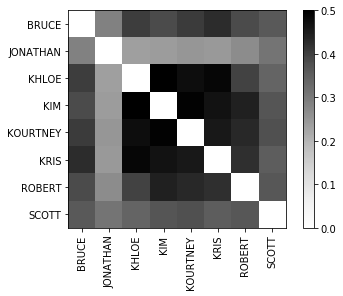

In [8]:
plt.imshow(j_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_good_speakers), good_speakers, rotation=90)
plt.yticks(range(n_good_speakers), good_speakers)
plt.show()

## Question 1b (Code Completition) Character Similiarity w/ Jaccard
To make it easier for us to analyze the matrix you will build a dictionary that shows the simlairity measurement between an arbitrary pair of characters. This function should take an arbitrary matrix (for the sake of future analysis that we will do) that is ordered by `good_speakers` and is of size `n_good_speakers` by `n_good_speakers`.

Please define the function below and ensure that the return format of your dictionary is the following scheme:

```
{(CHARACTER_NAME_A,CHARACTER_NAME_B): score_a_b,
...}
```

In [9]:
def sim_dict(input_sim_mat,input_good_speakers,input_n_speakers):
    """Returns a dictionary with the keys being tuple pairs of speakers and 
    values being similarity scores. 
    
    Note: The values should be in full-precision. 
    When printing, we will be rounding but leave the values return by 
    this function in full-precision. 
    
    The desired dictionary format should be the following
        {(CHARACTER_NAME_A,CHARACTER_NAME_B): score_a_b,
        ...}
    
    Params: {input_sim_mat: Numpy Array,
             input_good_speakers: List,
             input_n_speakers: Integer}
    Returns: Dict
    """
    # YOUR CODE HERE
    c2c_scores = {}
    for i in range(input_n_speakers):
        for j in range(input_n_speakers):
            c2c_scores[(input_good_speakers[i], input_good_speakers[j])] = input_sim_mat[i][j]
    return c2c_scores
    raise NotImplementedError()

In [10]:
jaccard_sim_dict = sim_dict(j_sim_matrix,good_speakers,n_good_speakers)

In [11]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that sim_dict returns the correct output"""
assert type(jaccard_sim_dict) == dict
assert jaccard_sim_dict[('BRUCE','BRUCE')] == 0.0
assert jaccard_sim_dict[('KIM','SCOTT')] < 0.5

## Question 1c (Code Completition): Character Similiarity w/ Jaccard
To make it easier for us to analyze the matrix we will be creating we will take an input similarity dictionary and return the most and least similar pairs. As a result, we want to return a tuple in the following format:
```
((MOST_SIMILAR_CHARACTER_PAIR,MOST_SIM_SCORE),
 (LEAST_SIMILAR_CHARACTER_PAIR,LEAST_SIM_SCORE))
```

In [12]:
def most_least_sim_pairs(input_sim_dict):
    """Returns a 2-element tuple list which shows 
    the most and least similar character pairs. 

    The desired tuple format should be the following
        ((MOST_SIMILAR_CHARACTER_PAIR,MOST_SIM_SCORE),
         (LEAST_SIMILAR_CHARACTER_PAIR,LEAST_SIM_SCORE))
    
    Note: Disregard pairs between the same person: i.e. (KIM,KIM)
    
    Params: {input_sim_dict: Dict}
    Returns: tuple
    """
    # YOUR CODE HERE
    pair_score = tuple()
    nzero_input_sim_dict = {key: value for key, value in input_sim_dict.items() if value != 0.}
    pair_score += (max(nzero_input_sim_dict.items(), key = lambda x: x[1]), )
    pair_score += (min(nzero_input_sim_dict.items(), key = lambda x: x[1]), )
    return pair_score
        
    raise NotImplementedError()

In [13]:
most_least_tup = most_least_sim_pairs(jaccard_sim_dict)
print("MOST SIMILAR: %s - %.2f" % most_least_tup[0])
print("LEAST SIMILAR: %s - %.2f" % most_least_tup[1])

MOST SIMILAR: ('KIM', 'KHLOE') - 0.50
LEAST SIMILAR: ('KHLOE', 'JONATHAN') - 0.24


In [14]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that most_least_sim_pairs returns the correct output"""
assert type(most_least_tup) == tuple
assert len(most_least_tup) == 2

## Question 2 (Code Completion): Character Similairty w/ Generalized Jaccard
The similarity measure that we took above doesn't take into account how often the characters say a word. To account for this, we can use Generalized Jaccard, an extension of Jaccard to weighted sets.

For each word $w$ and each character $C$, we compute the frequency weight $\text{tf}(w, C)$ as the ratio between the number of times $C$ says the word $w$, and the total number of words (good types) said by $C$. For example, if we had a character named Ilan, and all of the words that he said were "my name is ta ilan and i am your ta" the $\text{tf}(ta, ilan)$ would be $\frac{2}{10}$

Generalized Jaccard is:

$$ GJ(A, B) = \frac{\sum_{w \in \text{good types}} \text{min}(\text{tf}(w, A), \text{tf}(w, B))}
{\sum_{w \in \text{good types}} \text{max}(\text{tf}(w, A), \text{tf}(w, B))} $$

Note that Jaccard is equivalent to Generalized Jaccard if the weights are binarized by truncating all positive ones to 1.

Firstly, you will begin by defining a `tf` function below. 

In [15]:
# To help you, we have incuded this variable which is an inverse index for good_types
good_types_reverse_index = {t: i for i, t in enumerate(good_types)}

In [16]:
def tf(word_w,character_c,input_word_array):
    """ This function determines the term frequency weight which is the 
    ratio between the number of times an input character C says word W and 
    the total number of words said by character C.
    
    Note: Look at the exampled in the cell above with: tf(ta,ilan). 
          Please return answer in full preceision. 
          You should use the global variable: good_types_reverse_index
          in this function... This is for the sake of making a smaller arg list.
          This is different from the (unnormalized) TF you have seen in class.
    
    Params: {word_w: String,
             character_c: Integer (Index within good_speakers),
             input_word_array: Numpy array}
    Returns: Float
    """
    # YOUR CODE HERE
    word_idx = good_types_reverse_index[word_w]
    tf = input_word_array[character_c][word_idx]/sum(input_word_array[character_c])
    return tf
    raise NotImplementedError()

In [17]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that tf returns the correct output"""
assert tf('hi',3,word_array)*100 > 0.10

## Question 2b (Code Completion): Character Similarty w/ Generalized Jaccard
Now you will complete the function specification below, which will return a numpy array 
of character similarities done via Generalized Jaccard

In [18]:
def create_g_j_sim_mat(tf_method,input_word_array,input_good_types,input_n_speakers):
    """Returns a numpy array of shape n_speakers by n_speakers such that the 
    entry (ij) indicates the Generalized Jaccard Similarty between Speaker i and j.
    
    Note: Set diagnoals to 0.0 (As the similarity between the same character
    won't count)
    
    Hint: Use numpy primitives
    
    Params: {tf_method: Function (a,b,c) -> d,
             input_word_array: Numpy Array,
             input_good_types: List,
             input_n_speakers: Integer}
    Returns: numpy array
    """
    # YOUR CODE HERE
    tf_mat = np.copy(input_word_array)
    sum_words = np.sum(input_word_array, axis = 1)
    for k in range(len(input_good_types)):
        tf_mat[:, k] = input_word_array[:, k]/sum_words
        # We used matrix rather than tf_method to calculate term frequency here
        
        
    GJS = np.zeros((input_n_speakers, input_n_speakers))
    for i in range(input_n_speakers):
        for j in range(i+1, input_n_speakers):
                numerator = sum([min(tf_i, tf_j) for tf_i, tf_j in zip(tf_mat[i], tf_mat[j])])
                denominator = sum([max(tf_i, tf_j) for tf_i, tf_j in zip(tf_mat[i], tf_mat[j])])
                GJS[i][j] = GJS[j][i] = numerator/denominator
    return GJS
    raise NotImplementedError()

In [19]:
g_j_sim_matrix = create_g_j_sim_mat(tf,word_array,good_types,n_good_speakers)
g_jaccard_sim_dict = sim_dict(g_j_sim_matrix,good_speakers,n_good_speakers)

In [20]:
g_most_least_tup = most_least_sim_pairs(g_jaccard_sim_dict)
print("MOST SIMILAR: %s - %.2f" % g_most_least_tup[0])
print("LEAST SIMILAR: %s - %.2f" % g_most_least_tup[1])

MOST SIMILAR: ('KIM', 'KHLOE') - 0.72
LEAST SIMILAR: ('JONATHAN', 'ROBERT') - 0.49


In [21]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_g_j_sim_mat returns the correct output"""
assert type(g_j_sim_matrix) == np.ndarray
assert g_j_sim_matrix.shape == (8,8)
assert type(g_jaccard_sim_dict) == dict
assert g_j_sim_matrix[2][2] == 0.0
assert sum(g_j_sim_matrix[1,:]) > 3
assert g_jaccard_sim_dict['BRUCE','KIM'] > 0.5

In [22]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_g_j_sim_mat and most_least_sim_pairs returns the correct output"""
assert g_most_least_tup[0][0] == ('KHLOE', 'KIM') or g_most_least_tup[0][0] == ('KIM', 'KHLOE')

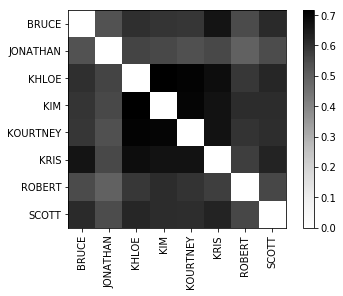

In [23]:
plt.imshow(g_j_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_good_speakers), good_speakers, rotation=90)
plt.yticks(range(n_good_speakers), good_speakers)
plt.show()

## Question 2c (Free Response): Character Similairty w/ Generalized Jaccard

Isn't it cool how we are able to analyze character similarity using just conversational data?! 
Be sure to investigate how the Generalized Jaccard similarity matrix differs from the standard Jaccard and how the character similairty pairs change. 

In the cell below, please use Markdown to observe any differences that you noticed between the heatmaps 
generated with Jaccard and Generalized Jaccard similaritiy measurements.

The most obvious difference is that the scores computed by Generalized Jaccard similarity measurements are higher and closer to each other comparing to the results from standard Jaccard. The color of Generalized Jaccard is darker on average. Jonathan is the least similar character in both heatmaps, but the character pairs with him in the least similar pair changes from Khloe to Robert.

## Question 3 (Code Completition): Character Pair Analysis w/ Generalized Jaccard
Leveraging the Generalized Jaccard similarity matrix: `g_j_sim_matrix` you will be doing analysis 
on character pairs and their average similarty in comparison to other pairs. The goal of this analysis is to determine which character is the most similar to everyone else and who is the least similar to everyone else. 

As a start, let us build a list of floats of size `n_good_speakers`, that corresponds to the average similarity between that character and all the rest of the characters. In the cell below, satisfy the specification and ensure that you leverage numpy primitives

In [24]:
def create_avg_sims(input_g_sim,input_n_speakers):
    """Returns a numpy array of size input_n_speaker that gives the average
       similairity between speaker i and everybody but the speaker itself. 
    
    Hint: It is recommended to use numpy primitives. 
    
    Note: You can not use the input_n_speakers if you 
    can satisfy the spec without using it. 
    
    Params: {input_g_sim: Numpy Matrix (Generalized Jaccard sim matrix),
             input_n_speakers: Integer}
    Returns: Numpy array
    """
    # YOUR CODE HERE
    return np.sum(input_g_sim, axis = 1)/(input_n_speakers-1)
    raise NotImplementedError()

In [25]:
avg_sims = create_avg_sims(g_j_sim_matrix,n_good_speakers)

In [26]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_avg_sims returns the correct output"""
assert type(avg_sims) == np.ndarray
assert avg_sims.shape == (8,)
assert sum(avg_sims) < 5

## Question 3b (Code Completition): Character Pair Analysis w/ Generalized Jaccard
This specific analysis concludes with the determination of which characters are the most and least similar to everyone else. 

As such, in the cell bellow satisfy the specification to by return a tuple in the following format:
```
(MOST_SIMILAR_CHARACTER_NAME,LEAST_SIMILAR_CHARACTER_NAME)
```

In [27]:
def most_least_char_sim(input_avg_sims,input_good_speakers):
    """Returns a Tuple which shows the most and least similar character 
       in relation to the rest of the characters. 

    The desired tuple format should be the following
        (MOST_SIMILAR_CHARACTER_NAME,LEAST_SIMILAR_CHARACTER_NAME)
    
    Hint: Use Numpy primitives
    
    Params: {input_avg_sims: Numpy Array,
             input_good_speakers: List}
    Returns: Tuple
    """
    # YOUR CODE HERE
    least_sim = np.argmin(input_avg_sims)
    most_sim = np.argmax(input_avg_sims)
    return (input_good_speakers[most_sim], input_good_speakers[least_sim],)
    raise NotImplementedError()

In [28]:
sim_pairs = most_least_char_sim(avg_sims,good_speakers)
print("MOST SIMILAR: %s" % sim_pairs[0])
print("LEAST SIMILAR: %s" % sim_pairs[1])

MOST SIMILAR: KHLOE
LEAST SIMILAR: JONATHAN


In [29]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that most_least_char_sim returns the correct output"""
assert type(sim_pairs) == tuple
assert len(sim_pairs) == 2

## Character interactions

In this section we will make the assumtion that, if speaker B says something immediately after speaker A, then it is in reply to speaker A's utterance. While this assumption is not correct in all cases (particularly for noisy transcript data) it should still give us some insight into how our characters are behaving. In many cases, making reasonable assumptions about your data can lead to new insights.

## Question 4 (Code Completion): Character Replies

In this question we will be looking at how often each character speaks to every other character.

In the cell bellow, satisfy the function specification: 

In [30]:
def create_reply_matrix(input_deduped_transcripts,input_good_speakers,input_n_speakers):
    """Returns a numpy array of shape n_speakers by n_speakers such that the 
    entry (ij) indicates the how many times speaker j replied to speaker i
    
    Note: Set diagnoals to 0.0 (As the replies between the same character does 
          not count)
    
    Params: {input_deduped_transcripts: List,
             input_good_speakers: List,
             input_n_speakers: Integer}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    reply_mat = np.zeros((input_n_speakers, input_n_speakers))
    for transcript in input_deduped_transcripts:
        speaker = transcript[1][0]['speaker']
        for line in range(1, len(transcript[1])):
            replier = transcript[1][line]['speaker']
            if replier != speaker and replier in input_good_speakers \
            and speaker in input_good_speakers:
                i = input_good_speakers.index(speaker)
                j = input_good_speakers.index(replier)
                reply_mat[i][j] += 1
                reply_mat[j][i] += 1
            speaker = replier       
    return reply_mat
    
    raise NotImplementedError()

In [31]:
reply_matrix = create_reply_matrix(deduped_transcripts,good_speakers,n_good_speakers)

In [32]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_reply_matrix returns the correct output"""
assert type(reply_matrix) == np.ndarray
assert reply_matrix[1][1] == 0.0
assert reply_matrix.shape == (8,8)
assert sum(reply_matrix[1]) > 70

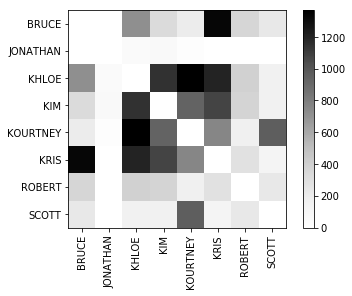

In [33]:
plt.imshow(reply_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_good_speakers), good_speakers, rotation=90)
plt.yticks(range(n_good_speakers), good_speakers)
plt.show()

## Question 4b (Free Response): Character Replies

In the cell below, please use Markdown to describe anything that you notice about the heatmap generated from the reply matrix. Anything you can capture about the communication between certain characters?

The communication between Kris and Bruce and that between Kourtney and Khloe seem to happen most frequently. On the other hand, Jonathan seldom talk to any other main characters.

## Question 5 (Code Completion): Character-Pair Specific Diction

In this analysis we will be answering the question: what are the most specific words used by each pair of characters?

For this analysis, we will take only the pairs of characters that exchanged at least 500 messages between them (*good pairs*), in either direction. As such, we will label these pairs in alphabetical order and build a matrix where the rows correspond to the pairs, and the columns to the *good type* words.

You will begin by satisfying the specification in the cell below and determining the good pairs. The return type of the function will be a list of tuples in the following format:
```
[(character_index_A,character_index_B),
...]
```

Note: We will be numerically sorting the good pairs later. 

Hint: You are to only look at the interaction between the pairs, not all words each person says. As such you should be only relying on the `reply_matrix`. 

In [34]:
def create_good_pairs(input_reply_matrix,input_n_speakers):
    """Returns a tuple list of good pairs in the following format:
        [(character_index_A,character_index_B),
        ...]
    
    Note: You should ensure that the pairs are in either direction i.e. if (1,2) exists than (2,1) 
    should not, as (1,2) already took account for the pairing. 
    
    Hint: In regards to the note, think about uniqueness constraints that could be obtained given 
    the fact that the character indexes are INTEGERS. i.e. How do databases handle uniqueness 
    constraints when building relationships between models that are indexed with integer-based columns?
    
    Params: {input_reply_matrix: Numpy array,
             input_n_speakers: Integer}
    Returns: List<Tuple>
    """
    # YOUR CODE HERE
    good_pairs = []
    for i in range(input_n_speakers):
        for j in range(i+1, input_n_speakers):
            if input_reply_matrix[i][j] >= 500:
                good_pairs.append((i,j,))
    return good_pairs
    raise NotImplementedError()

In [35]:
good_pairs = create_good_pairs(reply_matrix,n_good_speakers)
good_pairs.sort()

In [36]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_good_pairs returns the correct output"""
assert type(good_pairs) == list
assert reply_matrix[good_pairs[0]] + reply_matrix[good_pairs[0][::-1]] >= 500

In [37]:
# To help you for the next couple of functions. We recommend you use the following variables
# as well as the good_type_reverse_index variable defined before
n_good_pairs = len(good_pairs)
good_pairs_reverse_index = {t: i for i, t in enumerate(good_pairs)}
# We have attached a tokenize method that you should use below:
def tokenize(text):
    """Returns a list of words that make up the text.    
    Params: {text: String}
    Returns: Array
    """
    return [x for x in re.findall(r"[a-z]*", text.lower()) if x != ""]

## Question 5b (Code Completion): Character-Pair Specific Diction

As we continue the analysis we hope to build a pair-wise word matrix. This pair-wise matrix has rows that correspond to the pairs, and the columns that correspond to *good type* words. 

As such, in the cell below, fulfill the specification to build this `n_good_pairs` by `n_good_types` matrix:

In [40]:
def create_pair_words_mat(input_tokenize_method,
                          input_deduped_transcripts,
                          input_good_speakers,
                          input_n_speakers,
                          input_n_good_types,
                          input_n_good_pairs):
    """Returns a numpy array of shape n_good_pairs by n_good_types such that the 
    entry (ij) indicates the how many times pair i has said good type word j.
    
    Hint: You should use the global variables good_pairs_reverse_index and 
    good_types_reverse_index. 
    
    Params: {input_tokenize_method: Function a -> b,
             input_deduped_transcripts: List,
             input_good_speakers: List,
             input_n_speakers: Integer,
             input_n_good_types: Integer,
             input_n_good_pairs: Integer}
    Returns: Numpy array
    """
    # We are providing you the code structure below to help you get
    # started in the right direction. You may edit it, if you want.
    pair_words_mat = np.zeros((input_n_good_pairs, input_n_good_types))
    for key, t in input_deduped_transcripts:
        last_speaker = None
        for line in t:
            cur_speaker = line["speaker"]
            if (last_speaker in input_good_speakers and \
                cur_speaker in input_good_speakers and last_speaker != cur_speaker):
                i = input_good_speakers.index(last_speaker)
                j = input_good_speakers.index(cur_speaker)
    # YOUR CODE HERE
                pair_ij = (min(i,j), max(i,j), )
                if pair_ij in good_pairs_reverse_index.keys():
                    good_pair_idx = good_pairs_reverse_index[pair_ij]
                    tokenized_line = input_tokenize_method(line['text'])
                    for word in tokenized_line:
                        if word in good_types_reverse_index.keys():
                            good_type_idx = good_types_reverse_index[word]
                            pair_words_mat[good_pair_idx][good_type_idx] += 1
            last_speaker = cur_speaker
    return pair_words_mat
    raise NotImplementedError()

In [41]:
pair_words_mat = create_pair_words_mat(tokenize,
                                      deduped_transcripts,
                                      good_speakers,
                                      n_good_speakers,
                                      n_good_types,
                                      n_good_pairs)

In [42]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_pair_words_mat returns the correct output"""
assert type(pair_words_mat) == np.ndarray
assert pair_words_mat.shape == (9,4517)
assert sum(pair_words_mat[1]) > 8000
assert sum(pair_words_mat[:,8]) == 0.0

## Question 5c (Code Completion): Character-Pair Specific Diction

As we finish this analysis we end by scoring the words by the ratio between how often a given pair said it, and how often all of the *good pairs* said it. This can be done quite simply with numpy primitives.

In the cell below, complete the specification and return the weighted words by each pair:

In [43]:
def create_weighted_words(input_pair_words_mat,
                          input_n_good_types,
                          input_n_good_pairs):
    """Returns a numpy array of shape n_good_pairs by n_good_types such that the 
    entry (ij) indicates a weighted score showing how often a given pair said 
    a good type word
    
    Hint: Use numpy primitives to make this function optimal
    
    Note: Don't forget to add 1 to the sum of each column 
    to handle divide by 0 issues!
    
    Params: {input_pair_words_mat: Numpy array,
             input_n_good_types: Integer,
             input_n_good_pairs: Integer}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    weighted_words = np.zeros((input_n_good_pairs, input_n_good_types))
    sum_each_column = np.sum(input_pair_words_mat, axis = 0) + 1.0
    for i in range(input_n_good_pairs):
        weighted_words[i] = input_pair_words_mat[i]/sum_each_column
    return weighted_words
    raise NotImplementedError()

In [44]:
weighted_words = create_weighted_words(pair_words_mat,n_good_types,n_good_pairs)

In [45]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_weighted_words returns the correct output"""
assert type(weighted_words) == np.ndarray
assert weighted_words.shape == (9,4517)
assert sum(weighted_words[:,0]) > 0 and sum(weighted_words[:,0]) < 1
assert sum(weighted_words[5]) > 200

Now, we can display the top 10 words between good_pairs:

In [46]:
for i, j in good_pairs:
    print(good_speakers[i], good_speakers[j])
    words = weighted_words[good_pairs_reverse_index[i, j]]
    ranked = sorted(enumerate(words), key=lambda x:x[1], reverse=True)
    for index, score in ranked[:6]:
        print(round(score, 2), good_types[index])
    print()

BRUCE KHLOE
0.93 apparently
0.86 american
0.86 coats
0.86 fur
0.83 individual
0.8 dentist

BRUCE KRIS
0.89 golf
0.86 fabulous
0.8 chris
0.8 cutting
0.8 planners
0.75 accepted

KHLOE KIM
0.86 gives
0.86 sale
0.8 africa
0.75 bone
0.75 botox
0.75 except

KHLOE KOURTNEY
0.83 beast
0.83 compare
0.83 fear
0.83 organization
0.83 palms
0.83 posted

KHLOE KRIS
0.88 necessary
0.83 label
0.83 ladies
0.83 maker
0.83 shops
0.83 wind

KIM KOURTNEY
0.91 amusing
0.86 buys
0.83 read
0.83 sight
0.8 quiet
0.75 ho

KIM KRIS
0.86 flight
0.83 insensitive
0.8 slap
0.8 veil
0.8 yourselves
0.75 bite

KOURTNEY KRIS
0.86 bunny
0.86 desperate
0.86 hop
0.83 addiction
0.83 backup
0.83 cards

KOURTNEY SCOTT
0.92 cane
0.8 absurd
0.8 crib
0.75 hospital
0.71 tom
0.67 accessory



## Question 5c (Free Response): Character-Pair Specific Diction

Now we have some sensible results in understand the specific diction between character pairs. 


In the cell below, please use Markdown to note any interesting observations/analysis you can take-away from the results above. 

From the results above, Bruce and Khloe talk a lot about luxuries like fur coats. It seems that golf is the common hobby between Bruce and Kris. The most frequent topic between Khloe and Kim seems to be plastic surgery. Negative emotions such as fear is often involved in the conversation between Khloe and Kourtney. Khloe, Kris, Kim and Kourtney all love shopping very much. It seems that Kourtney and Kris talk about addiction to gambling and how they feel about it quite a lot. Kourtney and Scott are a couple but their relationship is not good. Their kid named Tom is the major topic in their conversation.  

## Question 6 (Code Completion): Gender and social interaction.

Often we might want to examine how interactions differ depending on the characteristics of the people involved. In this case we are interested in the extent to which people interact differently depending on the gender of the person they are talking too. 

For example, do women talk differently to other women than they do to men?

While social scientific research shows that gender is not always conceptualized as a binary attribute, for simplicity we assume that there are two genders present, male and female. We have provided a gender dictionary below (Note: Although it has been well publicized that one of the characters changed their gender during the show we consider them here as the gender generally associated with their name as given in the transcripts).

In this question we will start by building a matrix where the rows correspond to gender combinations, and the columns to the good type words. In this analyais we will consider all interactions, not just the good pairs (since no pairs with a man have more than 500 interactions). 

In the cell below, complete the specification by returning the desired Numpy array. 

Hint: You can reuse your helper functions from above or the logic in the your previous methods. 

In [47]:
# These are the genders that you will be working with
genders = {u'BRUCE': u'M',
            u'JONATHAN': u'M',
            u'KHLOE': u'F',
            u'KIM': u'F',
            u'KOURTNEY': u'F',
            u'KRIS': u'F',
            u'ROBERT':u'M',
            u'SCOTT': u'M'}
genders_index = {'M':0,'F':1}
gender_mat_index = {('M','M'):0,('M','F'):1,('F','M'):2,('F','F'):3}

In [48]:
def create_gender_words_mat(input_tokenize_method,
                            input_deduped_transcripts,
                            input_good_speakers,
                            input_n_good_types):
    """Returns a numpy array of shape 4 by n_good_types such that the 
    entry (ij) indicates the how many times gender pair i says word j.
    
    Hint: You should use the global variables:
        good_types_reverse_index,
        genders
        genders_index,
        gender_mat_index
    
    Params: {input_tokenize_method: Function (a -> b),
             input_deduped_transcripts: List,
             input_good_speakers: List,
             input_n_good_types: Integer}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    gender_word_mat = np.zeros((4, input_n_good_types))
    for key, t in input_deduped_transcripts:
        last_speaker = None
        for line in t:
            cur_speaker = line["speaker"]
            if (last_speaker in input_good_speakers and \
                cur_speaker in input_good_speakers and last_speaker != cur_speaker):
                gender_i = genders[last_speaker]
                gender_j = genders[cur_speaker]
                gender_pair_idx = gender_mat_index[(gender_i, gender_j,)]
                tokenized_line = input_tokenize_method(line['text'])
                for word in tokenized_line:
                    if word in good_types:
                        good_type_idx = good_types_reverse_index[word]
                        gender_word_mat[gender_pair_idx][good_type_idx] += 1
            last_speaker = cur_speaker
    return gender_word_mat
    raise NotImplementedError()

In [49]:
gender_words_mat = create_gender_words_mat(tokenize,deduped_transcripts,good_speakers,n_good_types)

In [50]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_gender_words_mat returns the correct output"""
assert type(gender_words_mat) == np.ndarray
assert gender_words_mat.shape == (4,4517)
assert sum(gender_words_mat[0]) > 5000

## Question 6b (Code Completion): Gender and social interaction

As we finish this portion of the analysis we end by scoring the words by the ratio between how often a given gender combination said it, and how often all of the combinations said it. This can be done quite simply with numpy primitives.

In the cell below, complete the specification and return the weighted words by each gender pair:

Hint: You can reuse your helper functions from above or the logic in the your previous methods. 

In [51]:
def create_gender_weighted_words(input_gender_words_mat,
                                 input_n_good_types):
    """Returns a numpy array of shape 4 by n_good_types such that the 
    entry (ij) indicates a weighted score showing how often a given gender
    pair said a good type word
    
    Hint: Use numpy primitives to make this function optimal
    
    Note: Don't forget to add 1 to the sum of each column 
    to handle divide by 0 issues!
    
    Params: {input_gender_words_mat: Numpy array,
             input_n_good_types: Integer}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    gender_weighted_words = np.zeros((4, input_n_good_types))
    sum_each_column = np.sum(input_gender_words_mat, axis = 0) + 1.0
    for i in range(4):
        gender_weighted_words[i] = input_gender_words_mat[i]/sum_each_column
    return gender_weighted_words
    raise NotImplementedError()

In [52]:
gender_weighted_words = create_gender_weighted_words(gender_words_mat,n_good_types)

In [53]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_gender_weighted_words returns the correct output"""
assert type(gender_weighted_words) == np.ndarray
assert gender_weighted_words.shape == (4,4517)
assert sum(gender_weighted_words[:,0]) > 0 and sum(gender_weighted_words[:,0]) < 1
assert sum(gender_weighted_words[3]) > 1000

In [54]:
for i, j in gender_mat_index.keys():
    print(i, j)
    words = gender_weighted_words[gender_mat_index[(i, j)]]
    ranked = sorted(enumerate(words), key=lambda x:x[1], reverse=True)
    for index, score in ranked[:10]:
        print(round(score, 2), good_types[index])
    print()

F F
0.96 shopping
0.95 snack
0.94 miles
0.94 necessary
0.93 promise
0.93 santa
0.92 alcoholic
0.92 intervention
0.92 wind
0.91 amusing

M M
0.75 simple
0.75 slowly
0.67 active
0.67 ale
0.67 amigos
0.67 bet
0.67 changing
0.67 deck
0.67 eveninto
0.67 filled

F M
0.96 pounds
0.92 acceptable
0.9 scream
0.88 learn
0.86 american
0.86 cheating
0.83 cutting
0.83 downstairs
0.83 individual
0.8 beef

M F
0.93 apparently
0.93 begins
0.88 r
0.86 coats
0.86 fur
0.83 forgiven
0.82 afraid
0.8 absurd
0.8 fabulous
0.75 burn



## Question 6c (Free Response): Gender and Social Interaction

These are some exciting results in regards to uncovering gender and the social interaction between gender pairs. 


In the cell below, please use Markdown to note any interesting observations/analysis you can take-away from the results above. 

From the results above, the most obvious conclusion is that female characters talk a lot about things that make them happy such as shopping and snack. Similarly, topics between male characters often include their hobbies such as beer, gambling and boat. In contrast, the topics between men and women are usually related to luxuries such as fur coats and their bad relationships between each other.

In [55]:
genders_list = [ str(genders[key]) for key in good_speakers ] 

## Question 7 (Code Completion): Gender Specific Word Choice

In this section of gender analysis we will be looking at what words are statistically *male* and which are *female*. To do this analysis you will be using the `word_array` and `genders_list` above which should line up with the x-axis of the `word_array` matrix. The goal of this analysis is to print the top 10 words said by each gender. 

To do this, you would sum over each word *(each column of the `word_array`)* said by the males and females and divide by the total words *(column-wise sum of the word_array)* used by both genders. 

In the cells below fulfill the specification to first return the top  10 *male* words and then the top 10 *female* words in the following format: 
```
[(word_1,score_1),
 (word_2,score_2),
...]
```

Note: Make sure to include smoothing!

Hint: It is recommended to sum with `np.ones` to account for smoothing

In [56]:
def top_10_words_by_gender(input_word_array,
                          input_genders_list,
                          input_good_types,
                          input_gender):
    """Returns a tuple list in the following format:
        [(word_1,score_1),
         (word_2,score_2),
        ...]
        that corresponds to the top 10 words said by a given gender. 
        
        input_gender is either 'F' or 'M'
    
    Note: Don't forget to add 1 to the sum of each column 
    to handle divide by 0 issues!
    
    Hint: Use numpy primitives to make this function optimal.
    Sum with np.ones to handle the divide by 0 issue.
    
    Params: {input_word_array: Numpy array,
             input_genders_list: List,
             input_good_types: List,
             input_gender: Char}
    Returns: List
    """
    # YOUR CODE HERE
    gender_idx = [i for i, x in enumerate(genders_list) if x == input_gender]
    gender_word_mat = input_word_array[gender_idx, :]
    gender_sum_column = np.sum(gender_word_mat, axis = 0)
    total_sum_column = np.sum(input_word_array, axis = 0) + 1.0
    gender_word_freq = gender_sum_column / total_sum_column
    sorted_gender_word_freq = sorted(enumerate(gender_word_freq), key = lambda x: x[1], reverse = True)
    word_idx, score = zip(*sorted_gender_word_freq[:10])
    top10_words_by_gender = list(zip(np.array(input_good_types)[list(word_idx)], score))
    return top10_words_by_gender
    raise NotImplementedError()

In [57]:
male_words = top_10_words_by_gender(word_array,genders_list,good_types,'M')
female_words = top_10_words_by_gender(word_array,genders_list,good_types,'F')

In [58]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that top_10_words_by_gender returns the correct output"""
assert type(male_words) == list
assert type(female_words) == list
assert 'bruiser' in [x[0] for x in male_words]
assert 'fur' in [x[0] for x in female_words]

In [59]:
print("Top Male words")
print("==============")
for word, score in male_words:
    print("%s: %.2f" % (word,score))
print("\nTop Female words")
print("==============")
for word, score in female_words:
    print("%s: %.2f" % (word,score))

Top Male words
truly: 0.95
bruiser: 0.94
graduated: 0.92
erika: 0.91
genetic: 0.89
katie: 0.89
pics: 0.89
yo: 0.88
email: 0.88
bro: 0.88

Top Female words
manager: 0.98
fur: 0.97
miles: 0.97
onkeeping: 0.97
shopping: 0.97
sign: 0.97
bachelorette: 0.97
site: 0.96
ta: 0.96
awful: 0.96


## Question 7b (Free Response): Gender Specific Word Choice

In the cell below, please use Markdown to note any interesting observations/analysis you can take-away from the results above. 

According to the result above, female characters tend to talk about luxury, shopping and marraige. On the other hand, men prefer to talk more about work, sports and girls who are not classified as major female characters.

## Question 8 (Extra Credit): Open-Ended Analysis for Extra Credit

Discuss something interesting that you found in the data, while looking at it in all the various ways we have during this assignment. Do you see anything that matches what we would know and expect about the characters? Anything contradictory?

In [60]:
# YOUR CODE HERE
"""Among the top ten words said by male characters, two female names "Erika" and "Katie" appear.
    They are not classified as major characters, but we are really curious about their identity 
    since their names appear so frequently.
"""
def erika_and_katie_info(input_deduped_transcripts, input_good_speakers):
    erika_and_katie = {}
    erika_and_katie['ERIKA'] = []
    erika_and_katie['KATIE'] = []
    for key, t in input_deduped_transcripts:
        for line in t:
            if (line['speaker'] in input_good_speakers and \
                'Erika' in line['text']) or ('Erika' in line['speaker']):
                erika_and_katie['ERIKA'].append((line['speaker'], line['text'],))
            if (line['speaker'] in input_good_speakers and \
                'Katie' in line['text']) or ('Katie' in line['speaker']):
                erika_and_katie['KATIE'].append((line['speaker'],line['text'],))
    return erika_and_katie
    raise NotImplementedError()

In [61]:
erika_katie_info = erika_and_katie_info(deduped_transcripts, good_speakers)
erika_katie_info

{'ERIKA': [('JONATHAN',
   'Joining Command PR West, we have Alex and Erika, our two newest associates.'),
  ('JONATHAN', "I don't trust Alex, I don't trust Erika."),
  ('JONATHAN',
   "And, Erika, like I'm noticing from your end it's making me really crazy that you're wearing flip-flops."),
  ('JONATHAN', "I need Erika to see what's going on here-- yeah, stand up."),
  ('JONATHAN', 'No. Erika, get up, seriously.'),
  ('JONATHAN', 'No, Erika looks great, but not for this job.'),
  ('JONATHAN', "Erika, that was frickin' awesome."),
  ('JONATHAN', 'Erika, that is so rude to do to me.'),
  ('JONATHAN',
   "I met Erika at this party a few weeks ago, we've been chatting and texting, and I can't wait to get to this dinner so we can start to learn a lot more about each other."),
  ('JONATHAN',
   "I'm really feeling Erika, and I really could see myself having a second date with her, which is very, very rare for me.")],
 'KATIE': [('JONATHAN',
   "And Katie who I took with me from New York, wh

From the text above we find that both Katie and Erika are related to one major character: Jonathan. Erika is Jonathan's associate. And it seems that Katie works for Jonathan as well. We also notice that Jonathan loves Erika very much. This could explain why Jonathan mentioned Erika's name so many times.

### Can't get enough of language and information?  

We have more!  Check out **A2ExtraCredit** for a chance to analyze linguistic priming between the Kardashians and get some super-valuable extra credit points.  **Highly recommended**

# This is the end of Assignment 2